In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
import polars as pl
import dask.array as da
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
ds_cesm["theta"] = (ds_cesm["t"] * (1000 / ds_cesm["lev"]) ** KAPPA).astype(np.float32)
ds_cesm = ds_cesm.drop_vars("t")
dh = DataHandler.from_basepath_and_da("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/results", ds_cesm)
exp = JetFindingExperiment(dh)
all_jets_one_df = exp.find_jets()
exp.props_as_df()

In [6]:
width = []
da = exp.ds["s"]
indexer = iterate_over_year_maybe_member(all_jets_one_df, da)
for idx1, idx2 in indexer:
    these_jets = all_jets_one_df.filter(*idx1)
    da_ = compute(da.sel(**idx2), progress_flag=True)
    width_ = compute_widths(these_jets, da_)
    width.append(width_)

[########################################] | 100% Completed | 101.82 ms


/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:715: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  da["time"] = da.indexes["time"].to_datetimeindex(time_unit="us")


InvalidOperationError: trigonometry operation not supported for dtype `null`

In [13]:
width_ = compute_widths(these_jets, da_)

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:716: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  da["time"] = da.indexes["time"].to_datetimeindex(time_unit="us")


  0%|          | 0/49 [00:08<?, ?it/s]


KeyboardInterrupt: 

# past and future props

In [4]:
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.lines import Line2D 
def periodic_rolling(df: pl.DataFrame, winsize: int, data_vars: list):
    halfwinsize = winsize // 2
    other_columns = get_index_columns(df, ("member", "jet"))
    descending = [False, *[col == "jet" for col in other_columns]]
    len_ = [df[col].unique().len() for col in other_columns]
    len_ = np.prod(len_)
    df = df.sort(["time", *other_columns], descending=descending)
    df = pl.concat([df.tail(halfwinsize * len_).with_columns(pl.col("time") - 366), df, df.head(halfwinsize * len_).with_columns(pl.col("time") + 366)])
    df = df.rolling(pl.col("time"), period=f"{winsize}i", offset=f"-{halfwinsize + 1}i", group_by=other_columns).agg(*[pl.col(col).mean() for col in data_vars])
    df = df.sort(["time", *other_columns], descending=descending)
    df = df.slice(halfwinsize * len_, 366 * len_)
    return df

def plot_seasonal(data_vars: list, props_as_df: pl.DataFrame, nrows: int = 3, ncols: int = 4, clear: bool = True, suffix: str = ""):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*2.4), tight_layout=True, sharex="all")
    axes = axes.flatten()
    jets = props_as_df["jet"].unique().to_numpy()
    member = [pl.col("member")] if "member" in props_as_df.columns else []
    past_props = props_as_df.filter(pl.col("time").dt.year() < 2025)
    future_props = props_as_df.filter(pl.col("time").dt.year() >= 2025)
    for k, df in enumerate([past_props, future_props]):
        ls = "solid" if k == 0 else "dashed"
        gb = df.group_by([*member, pl.col("time").dt.ordinal_day(), pl.col("jet")], maintain_order=True)
        means = gb.mean().cast({"time": pl.Int32})
        means = periodic_rolling(means, 15, data_vars)
        x = means["time"].unique()
        if "member" in props_as_df.columns:
            means = means.group_by(["time", "jet"], maintain_order=True).mean().drop("member")
        for varname, ax in zip(data_vars, axes.ravel()):
            dji = (varname == "double_jet_index")
            ys = means[varname].to_numpy().reshape(366, 2)
            if varname == "width":
                pre = "k"
                ys = ys / 1000
            else:
                pre = ""
            for i in range(2):
                color = "black" if dji else COLORS[2 - i]
                ax.plot(x, ys[:, i], lw=3, color=color, zorder=10, ls=ls)
                if dji:
                    break
            ax.set_title(f"{PRETTIER_VARNAME.get(varname, varname)} [{pre}{UNITS.get(varname, '')}]")
            ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
            ax.xaxis.set_major_formatter(DateFormatter("%b"))
            ax.set_xlim(min(x), max(x))
            if varname == "mean_lev" and (k == 0):
                ax.invert_yaxis()
            # ylim = ax.get_ylim()
            # wherex = np.isin(x.month, [6, 7, 8])
            # ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
            # ax.set_ylim(ylim)
        if k == 0:
            continue
        handles = [
            Line2D([0], [0], color=COLORS[2], lw=2),
            Line2D([0], [0], color=COLORS[1], lw=2),
            Line2D([0], [0], color="black", lw=2, ls="solid"),
            Line2D([0], [0], color="black", lw=2, ls="dashed"),
        ]
        labels = ["STJ", "EDJ", "1980-2009", "2070-2099"]
        axes.ravel()[0].legend(handles[2:], labels[2:], ncol=1, framealpha=1, loc="center left").set_zorder(102)
        axes.ravel()[2].legend(handles[:2], labels[:2], ncol=2, framealpha=1, loc="upper right").set_zorder(102)
    # plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

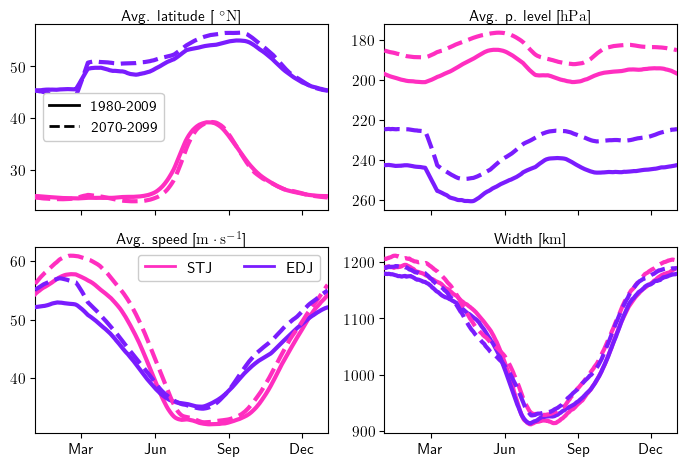

In [5]:
data_vars = ["mean_lat", "mean_lev", "mean_s", "width"]
plot_seasonal(data_vars, props_cesm, nrows=2, ncols=2, clear=False, suffix="_subset")
plt.savefig(f"{FIGURES}/jet_props_cesm/seasonal_subset.png")

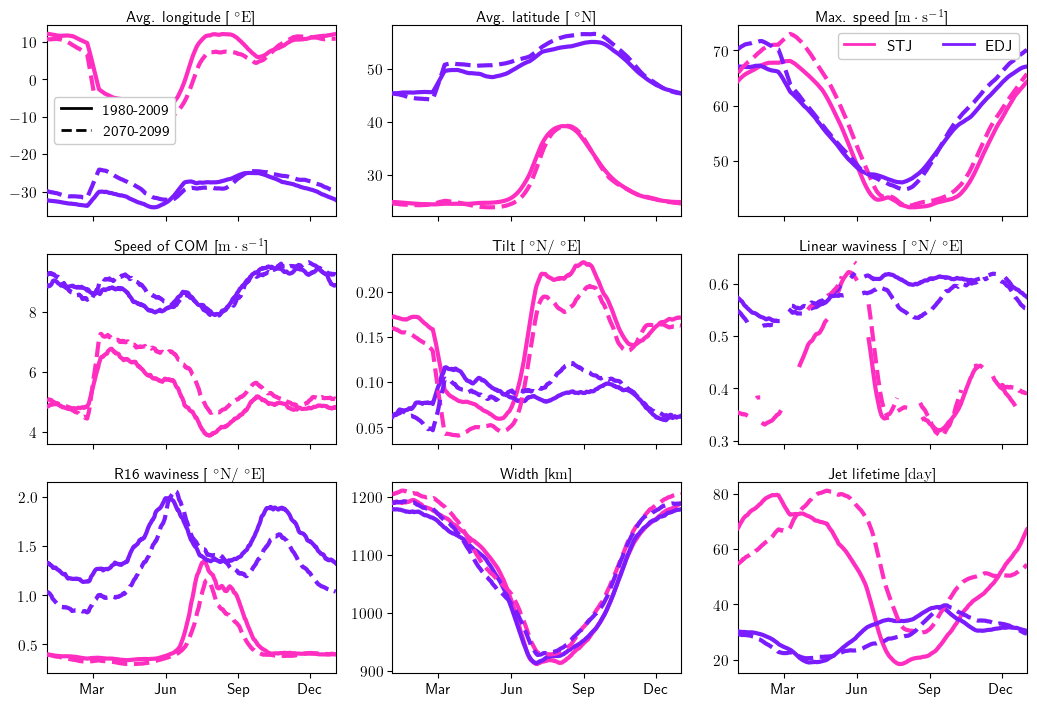

In [6]:
data_vars = ["mean_lon", "mean_lat", "s_star", "com_speed", "tilt", "waviness1", "wavinessR16", "width", "persistence"]
plot_seasonal(data_vars, props_cesm, nrows=3, ncols=3, clear=False)
plt.savefig(f"{FIGURES}/jet_props_cesm/seasonal.png")

In [ ]:
fig, axes = plt.subplots(12, 2, figsize=(4, 22))
for month in range(1, 13):
    jets_ = jets_cesm.filter(pl.col("time").dt.month() == month)
    axes[month - 1, 0].hexbin(jets_["lon"], jets_["lat"], gridsize=25)
    axes[month - 1, 1].hexbin(jets_["lon"], jets_["lat"], gridsize=25, C=jets_["is_polar"].cast(pl.UInt8), cmap=BLUEWHITERED)